In [1]:
#  STEP 1: Load and randomize 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# path to the CLEAN dataset from notebook 01
clean_path = r"C:/pynew/Lib/Final Project New/US_Airline_Fares_Clean.csv"

df = pd.read_csv(clean_path, low_memory=False)  # low_memory=False only for prevent warning
print("shape before shuffle:", df.shape)

shape before shuffle: (237985, 15)


In [5]:
# --- 1.5: Supervised setup --regression
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# target regression
y = df["fare"]

# numeric features 
num_cols = ["nsmiles", "passengers", "large_ms", "fare_lg", "lf_ms", "fare_low"]

# simple dummies for carriers (WN, AA, DL) like 02_Preprocessing
df["carrier_is_WN"] = (df["carrier_low"] == "WN").astype(int)
df["carrier_is_AA"] = (df["carrier_low"] == "AA").astype(int)
df["carrier_is_DL"] = (df["carrier_low"] == "DL").astype(int)
cat_cols = ["carrier_is_WN", "carrier_is_AA", "carrier_is_DL"] # categorical

# build X
X = df[num_cols + cat_cols]
print("X shape:", X.shape, "| y shape:", y.shape)

# Split (80/20)  shuffle is default, no stratify (regression)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)  # random_state = seed to repeat same split

# Scale features fit on train, transform on test (avoid leakage)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # fit only on train
X_test  = scaler.transform(X_test)

print("train:", X_train.shape, "test:", X_test.shape)


X shape: (237985, 9) | y shape: (237985,)
train: (190388, 9) test: (47597, 9)


In [18]:
# STEP 2: Build regression model
layer = tf.keras.layers

regression_model = tf.keras.Sequential([
    layer.Input(shape=(X_train.shape[1],)),  # num of features
    layer.Dense(32, activation='relu'),
    layer.Dense(16, activation='relu'),
    layer.Dense(1)  # regression -> no activation
])

In [19]:
regression_model.compile( optimizer='adam', loss='mse', metrics=['mae'])
  # mean square error (smooth), mean absolute error (interpretable)

In [20]:
#Train model with early stopping

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,             # si no mejora en 10 epochs, se detiene
    restore_best_weights=True
)

history = regression_model.fit( X_train, y_train,
    epochs=200, validation_split=0.1,
    callbacks=[early_stop], verbose=1)

Epoch 1/200
5355/5355 ━━━━━━━━━━━━━━━━━━━━ 9s 1ms/step - loss: 3308.6782 - mae: 28.0185 - val_loss: 262.7614 - val_mae: 9.3818
Epoch 2/200
5355/5355 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 248.7871 - mae: 8.9980 - val_loss: 231.0380 - val_mae: 8.7547
Epoch 3/200
5355/5355 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 229.1783 - mae: 8.4200 - val_loss: 218.5420 - val_mae: 8.2755
Epoch 4/200
5355/5355 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 221.4282 - mae: 8.1875 - val_loss: 215.2402 - val_mae: 8.0737
Epoch 5/200
5355/5355 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 216.4203 - mae: 8.0219 - val_loss: 214.0869 - val_mae: 8.0553
Epoch 6/200
5355/5355 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 213.2870 - mae: 7.9315 - val_loss: 209.5697 - val_mae: 7.9437
Epoch 7/200
5355/5355 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step - loss: 211.5708 - mae: 7.8739 - val_loss: 207.6099 - val_mae: 7.5908
Epoch 8/200
5355/5355 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 209.9091 - mae: 7.8177 - val_loss: 205.8910 - val_mae: 7.702

Best epoch: 32 | val_mse=197.41 | val_mae=7.34
Test MSE: 190.21
Test MAE: 7.27


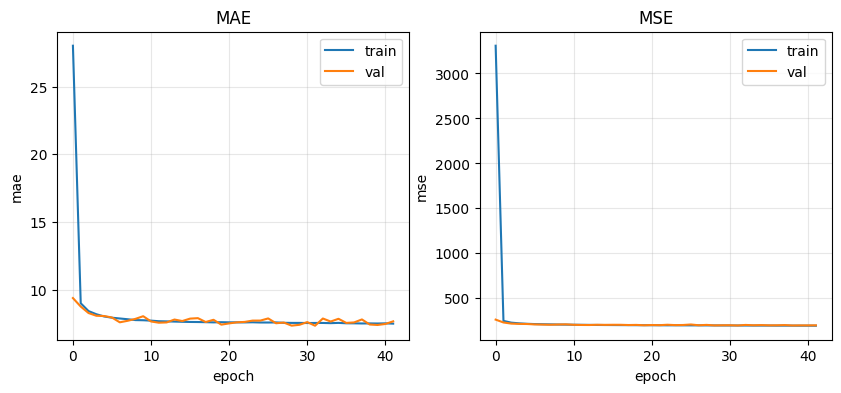

In [21]:
# STEP 4: Evaluate + training curves

import numpy as np
import matplotlib.pyplot as plt

# best epoch reported by EarlyStopping
best = np.argmin(history.history['val_loss']) + 1
print(f"Best epoch: {best} | "
      f"val_mse={history.history['val_loss'][best-1]:.2f} | "
      f"val_mae={history.history['val_mae'][best-1]:.2f}")

# test metrics
test_mse, test_mae = regression_model.evaluate(X_test, y_test, verbose=0)
print(f"Test MSE: {test_mse:.2f}")
print(f"Test MAE: {test_mae:.2f}")

# curves (train vs val)
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.title('MAE'); plt.xlabel('epoch'); plt.ylabel('mae'); plt.legend(); plt.grid(True, alpha=.3)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('MSE'); plt.xlabel('epoch'); plt.ylabel('mse'); plt.legend(); plt.grid(True, alpha=.3)

plt.show()


In [23]:
# STEP 5: Post-model analysis

# predictions on test set
y_pred = regression_model.predict(X_test).ravel()

print("y_test shape:", y_test.shape)
print("y_pred shape:", y_pred.shape)


1488/1488 ━━━━━━━━━━━━━━━━━━━━ 1s 804us/step
y_test shape: (47597,)
y_pred shape: (47597,)


Test MSE (manual): 190.21
Test MAE (manual): 7.27


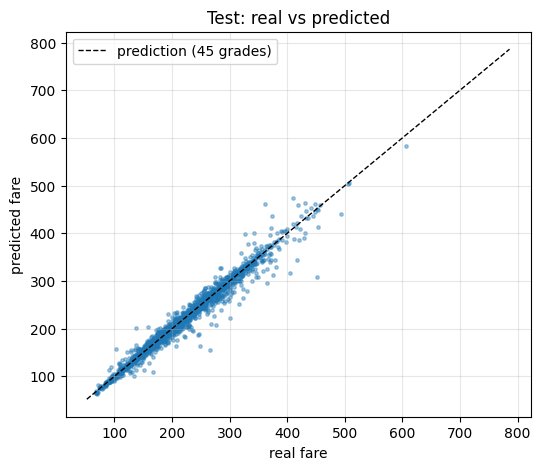

In [27]:
# Compare y_test vs y_pred

from sklearn.metrics import mean_squared_error, mean_absolute_error

# metrics
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)

print(f"Test MSE (manual): {mse_test:.2f}")
print(f"Test MAE (manual): {mae_test:.2f}")

# scatter plot: real vs predicted
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
plt.scatter(y_test[:2000], y_pred[:2000], s=6, alpha=0.4)
m = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(m, m, 'k--', lw=1, label="prediction (45 grades)")   # 45 grades line
plt.title('Test: real vs predicted')
plt.xlabel('real fare'); plt.ylabel('predicted fare')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


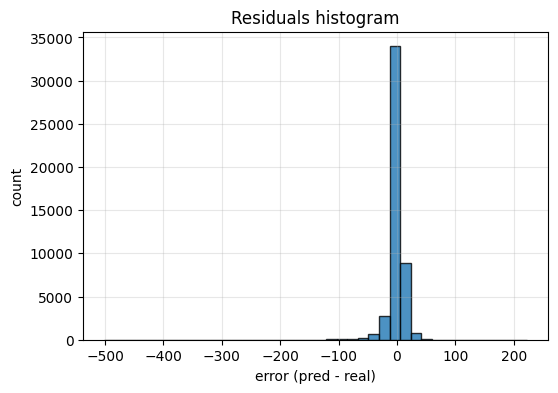

Residuals mean (should be near 0): -0.36
Residuals std: 13.787


In [33]:
# STEP 6: Residuals histogram
# residuals = prediction error
res = y_pred - y_test.values

plt.figure(figsize=(6,4))
plt.hist(res, bins=40, alpha=0.8, edgecolor="black")  # add borders
plt.title("Residuals histogram")
plt.xlabel("error (pred - real)")
plt.ylabel("count")
plt.grid(True, alpha=0.3)
plt.show()

print("Residuals mean (should be near 0):", np.mean(res).round(3))
print("Residuals std:", np.std(res).round(3))


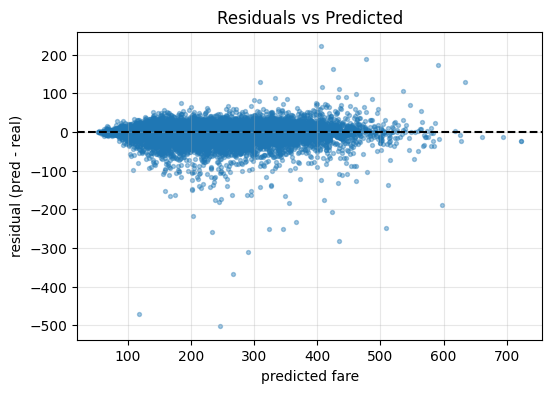

In [34]:
# 6.1 -- Residuals vs Predicted
# check if errors grow with the prediction)

plt.figure(figsize=(6,4))
plt.scatter(y_pred, res, s=8, alpha=0.4)
plt.axhline(0, color="black", linestyle="--")   # reference line (no error)
plt.title("Residuals vs Predicted")
plt.xlabel("predicted fare")
plt.ylabel("residual (pred - real)")
plt.grid(True, alpha=0.3)
plt.show()


In [35]:
# Residuals show how far predictions are from real values.
# Most errors near 0 , model is balanced.
# Distant bars from 0 = outliers , maybe cases where model failed more

In [38]:
#  6.2: Build a results table with context (routes, carrier, etc.)

# base residual table
res_df = pd.DataFrame({
    "idx": y_test.index.values,     # original row id
    "real_fare": y_test.values,
    "pred_fare": y_pred
})
res_df["residual"] = res_df["pred_fare"] - res_df["real_fare"]
res_df["abs_res"] = np.abs(res_df["residual"])

# add context from original dataset
cols_to_show = ["city1", "city2", "carrier_low", "nsmiles", "passengers"]
res_df = res_df.merge(df[cols_to_show], left_on="idx", right_index=True)

print(res_df.head(10))



      idx  real_fare   pred_fare   residual    abs_res  \
0  222226     254.54  267.064667  12.524667  12.524667   
1   17995     182.63  186.884247   4.254247   4.254247   
2  155119     162.77  163.191956   0.421956   0.421956   
3  209508     163.52  147.534393 -15.985607  15.985607   
4  217172     196.81  197.874039   1.064039   1.064039   
5  154674     125.69  128.689774   2.999774   2.999774   
6   11537     174.29  188.325378  14.035378  14.035378   
7   74173     131.18  133.883392   2.703392   2.703392   
8  150143     256.84  285.069977  28.229977  28.229977   
9  164690     141.83  138.179047  -3.650953   3.650953   

                                   city1  \
0  San Francisco, CA (Metropolitan Area)   
1                            Phoenix, AZ   
2                            Houston, TX   
3                            Chicago, IL   
4                        San Antonio, TX   
5                             Dayton, OH   
6    Los Angeles, CA (Metropolitan Area)   
7        

In [41]:
# table shows worst prediction errors with route and carrier info
# we see big errors in long routes with very few passengers

# 6.3 --- >Show worst prediction errors with route info

worst_errors = res_df.sort_values("abs_res", ascending=False).head(10)
print(worst_errors[["idx","real_fare","pred_fare","residual","abs_res",
                    "city1","city2","carrier_low","nsmiles","passengers"]])

          idx  real_fare   pred_fare    residual     abs_res  \
3949   103928     747.88  246.658371 -501.221629  501.221629   
32550  117851     588.90  117.008461 -471.891539  471.891539   
29374   97280     633.98  266.246429 -367.733571  367.733571   
20213  140964     601.86  290.280640 -311.579360  311.579360   
16762  135975     717.86  434.715698 -283.144302  283.144302   
35434  122875     491.54  233.696503 -257.843497  257.843497   
4568   174796     597.60  345.450287 -252.149713  252.149713   
44629  180614     573.72  323.599213 -250.120787  250.120787   
26012  114723     757.81  509.305176 -248.504824  248.504824   
41996  187558     598.70  366.686951 -232.013049  232.013049   

                                       city1  \
3949     Los Angeles, CA (Metropolitan Area)   
32550  New York City, NY (Metropolitan Area)   
29374      Cleveland, OH (Metropolitan Area)   
20213    Los Angeles, CA (Metropolitan Area)   
16762                  Dallas/Fort Worth, TX   
35434  

In [42]:
# about 6.2 ---> res_df.head(10) = first examples only
# about 6.3--->worst_errors = real outliers (largest prediction mistakes)
# these help us see where the model struggles most

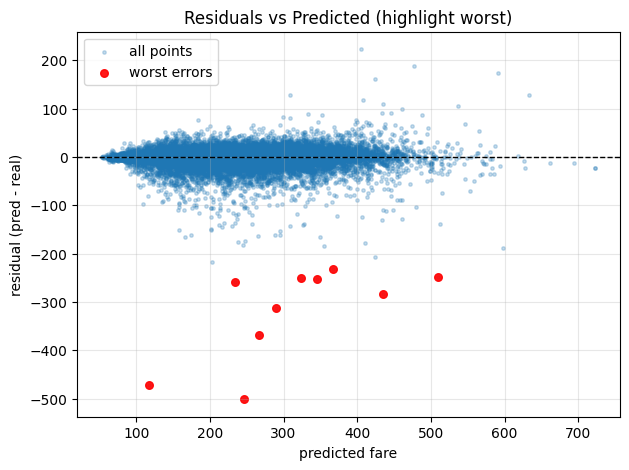

In [43]:
# 6.4: Residuals vs Predicted (highlight worst errors)

plt.figure(figsize=(7,5))

# all points (light gray)
plt.scatter(y_pred, res, s=6, alpha=0.25, label="all points")

# highlight worst errors (red)
we_idx = worst_errors["idx"].values
mask_we = np.isin(y_test.index.values, we_idx)

plt.scatter(y_pred[mask_we], res[mask_we], s=30, alpha=0.9, c="red", label="worst errors")

plt.axhline(0, color="black", linestyle="--", lw=1)
plt.title("Residuals vs Predicted (highlight worst)")
plt.xlabel("predicted fare")
plt.ylabel("residual (pred - real)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [44]:
# residual = pred - real (0 is perfect)
# red points = largest absolute errors
# pattern check: if spread grows with price, model struggles on high fares

In [45]:
# STEP 7: Show best prediction cases

# table shows flights with smallest residuals (almost perfect prediction)

best_predictions = res_df.sort_values("abs_res", ascending=True).head(10)
print(best_predictions[["idx","real_fare","pred_fare","residual","abs_res",
                        "city1","city2","carrier_low","nsmiles","passengers"]])


          idx  real_fare   pred_fare  residual   abs_res  \
6771   122101     192.92  192.920044  0.000044  0.000044   
33140  203380     223.32  223.320389  0.000389  0.000389   
17403  214972     172.43  172.429504 -0.000496  0.000496   
16351   42240     251.78  251.780533  0.000533  0.000533   
870    166977     180.55  180.549179 -0.000821  0.000821   
43604  207916     276.41  276.410980  0.000980  0.000980   
16693   86697     476.28  476.278961 -0.001039  0.001039   
38982  203915     222.58  222.581131  0.001131  0.001131   
32862  165547     177.45  177.451141  0.001141  0.001141   
38544   85618     267.25  267.248688 -0.001312  0.001312   

                                     city1  \
6771                         Lexington, KY   
33140      Atlanta, GA (Metropolitan Area)   
17403                          Chicago, IL   
16351                          Houston, TX   
870                             Denver, CO   
43604                           Albany, NY   
16693  Los Angele

In [46]:
# table shows best predictions (almost 0 error)
# usually medium routes with normal passengers

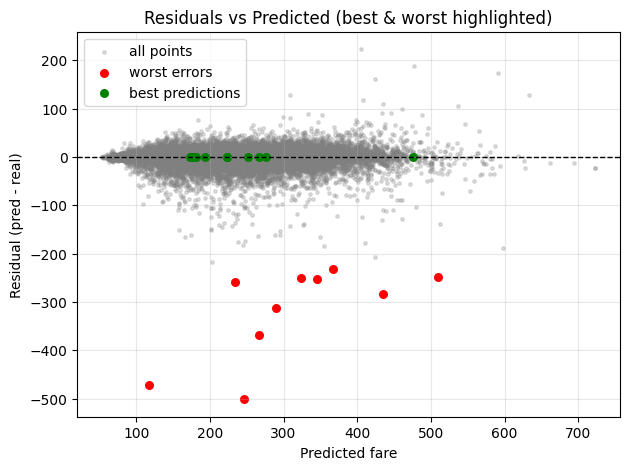

In [48]:
# -- 7.1: Residuals vs Predicted (highlight best & worst)

plt.figure(figsize=(7,5))

# all points (light gray)
plt.scatter(y_pred, res, s=6, alpha=0.25, c="gray", label="all points")

# highlight worst errors (red)
we_idx = worst_errors["idx"].values
mask_we = np.isin(y_test.index.values, we_idx)
plt.scatter(y_pred[mask_we], res[mask_we], s=30, c="red", label="worst errors")

# highlight best predictions (green)
bp_idx = best_predictions["idx"].values
mask_bp = np.isin(y_test.index.values, bp_idx)
plt.scatter(y_pred[mask_bp], res[mask_bp], s=30, c="green", label="best predictions")

# reference line
plt.axhline(0, color="black", linestyle="--", lw=1)

plt.title("Residuals vs Predicted (best & worst highlighted)")
plt.xlabel("Predicted fare")
plt.ylabel("Residual (pred - real)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [49]:
# scatter helps to see error distribution
# red = bad cases, 
# green = good cases
# if errors grow with fare, model struggles on expensive flights

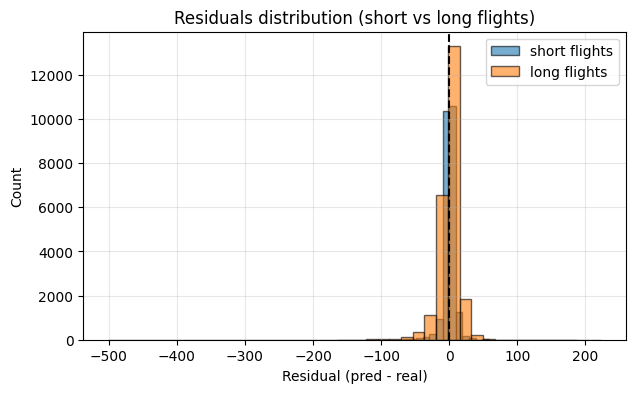

In [53]:
#  7.2: Residuals grouped by distance (short vs long)

# ensure there are no NaNs in used columns
tmp = res_df.dropna(subset=["nsmiles", "residual"]).copy()

# median distance
median_dist = tmp["nsmiles"].median()

# masks aligned with tmp
mask_short = tmp["nsmiles"] <= median_dist
short_res = tmp.loc[mask_short, "residual"]
long_res  = tmp.loc[~mask_short, "residual"]

plt.figure(figsize=(7,4))
plt.hist(short_res, bins=40, alpha=0.6,edgecolor="black", label="short flights")
plt.hist(long_res,  bins=40, alpha=0.6,edgecolor="black", label="long flights")
plt.axvline(0, color="black", linestyle="--")

plt.title("Residuals distribution (short vs long flights)")
plt.xlabel("Residual (pred - real)")
plt.ylabel("Count")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [54]:
#The plot shows that residual errors are larger for long-distance routes.
#Short routes (blue) have smaller prediction errors. 
# Maybe our model fits better short flights than very long ones.

city2
Bozeman, MT          302.684448
Palm Springs, CA     292.897949
Key West, FL         286.960541
Fayetteville, AR     262.061005
Traverse City, MI    254.917557
Harrisburg, PA       253.539841
San Diego, CA        253.513535
Cincinnati, OH       251.812958
Knoxville, TN        251.367523
Memphis, TN          248.027161
Name: pred_fare, dtype: float32


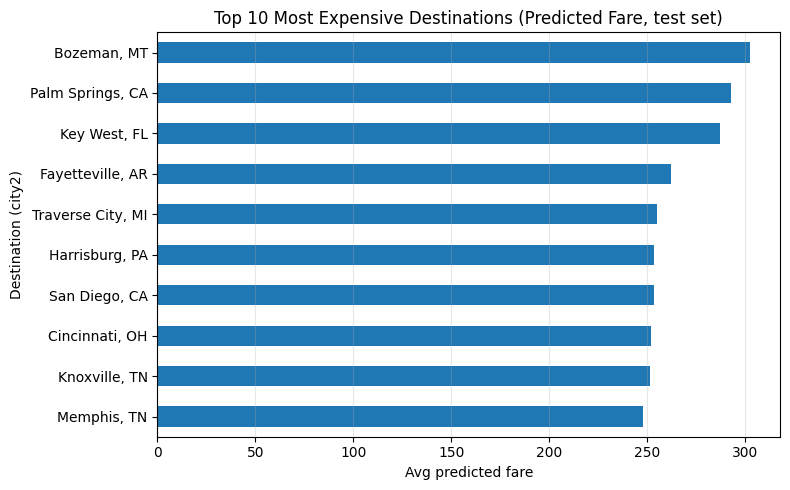

In [55]:
# ----> STEP 8: Top expensive destinations (test set, predicted fares)
#we want to see which destinations have highest predicted fare on average

# 8.0: build a tidy table: destination + mean predicted fare
top_dest = (res_df.groupby("city2")["pred_fare"]
            .mean()
            .sort_values(ascending=False)
            .head(10))

print(top_dest)

# 8.1: bar chart 
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
top_dest[::-1].plot(kind="barh")   # reverse so the largest is at the top
plt.xlabel("Avg predicted fare")
plt.ylabel("Destination (city2)")
plt.title("Top 10 Most Expensive Destinations (Predicted Fare, test set)")
plt.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


quarter                     1           2           3           4
city2                                                            
Bozeman, MT        332.070007         NaN  273.299988         NaN
Palm Springs, CA   278.309998  323.119995         NaN  307.750000
Key West, FL       293.320007  256.829987         NaN  272.559998
Fayetteville, AR   258.880005  190.460007  279.500000  299.119995
Traverse City, MI         NaN         NaN  254.919998         NaN
Harrisburg, PA     266.579987  275.720001  219.119995  265.929993
San Diego, CA      255.759995  262.640015  242.889999  252.039993
Cincinnati, OH     270.269989  241.809998  252.979996  244.360001
Knoxville, TN      241.520004  227.860001  250.089996  264.459991
Memphis, TN        238.330002  257.350006  252.149994  240.649994


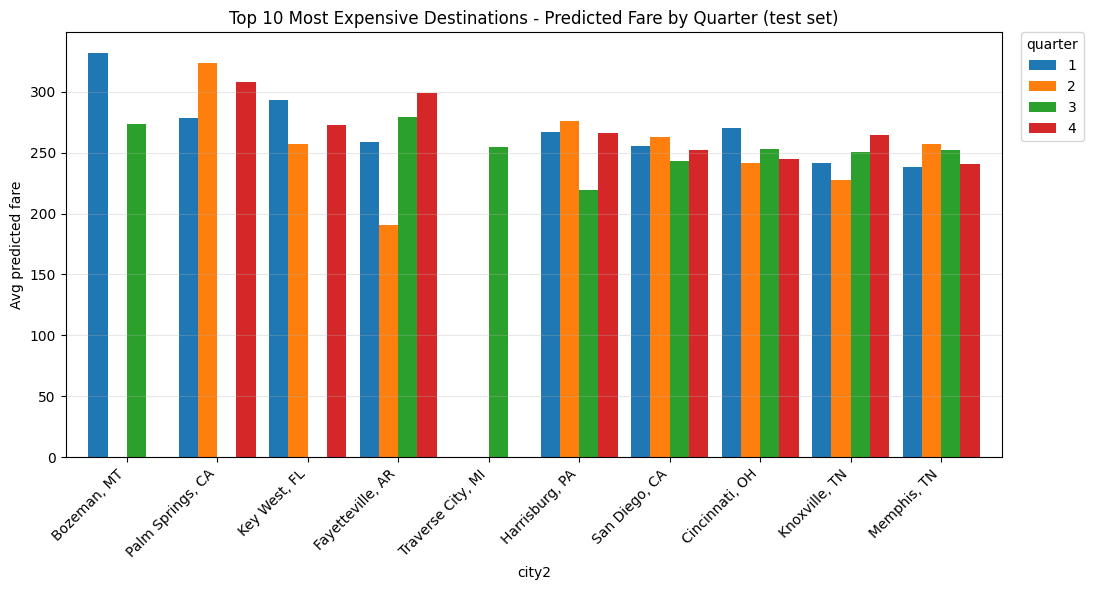

quarter                                1          2           3       4
city2                                                                  
Rapid City, SD                 82.809998        NaN         NaN     NaN
Provo, UT                      90.360001  94.669998   78.650002   88.25
Punta Gorda, FL                      NaN  91.010002         NaN     NaN
Lansing, MI                    91.550003        NaN         NaN     NaN
Trenton, NJ                   100.360001  72.849998   96.330002     NaN
St. Cloud, MN                 100.150002        NaN         NaN     NaN
Springfield, IL                      NaN  98.120003         NaN  104.07
Rockford, IL                  103.660004        NaN         NaN     NaN
Sanford, FL                          NaN        NaN  106.480003     NaN
Saginaw/Bay City/Midland, MI  108.839996        NaN         NaN     NaN


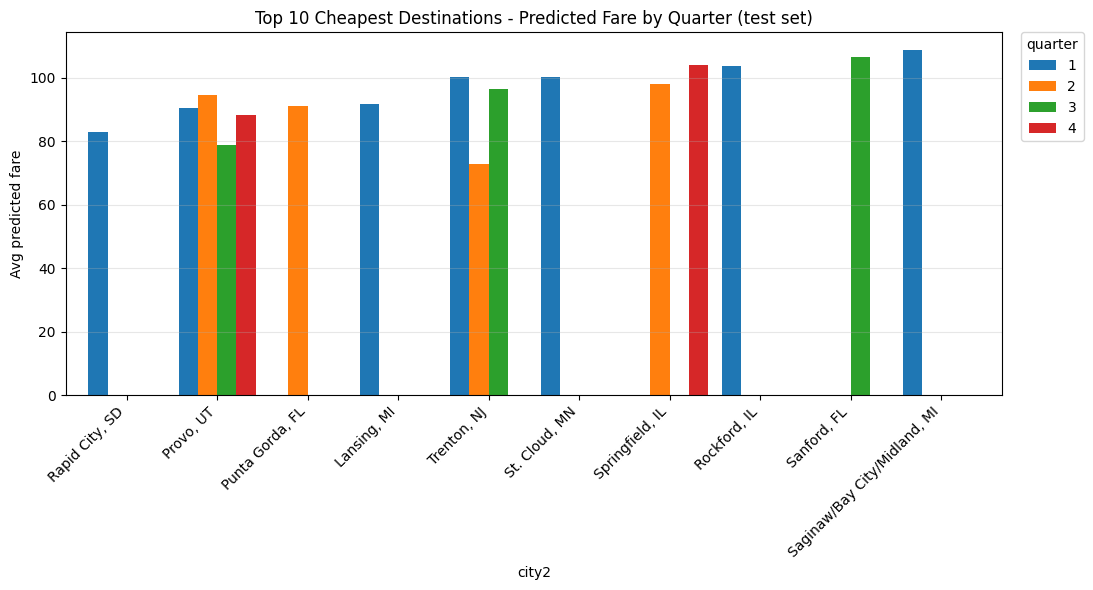

In [61]:
# --8.2--: Destinations by quarter (most expensive & cheapest) 


#overall mean predicted fare per destination (city2)
dest_mean = (res_df.groupby("city2")["pred_fare"]
             .mean()
             .sort_values(ascending=False))

top10_expensive = dest_mean.head(10).index            # 10 most expensive
top10_cheap     = dest_mean.tail(10).sort_values().index  # 10 cheapest (sorted low ->high)

# Helper: build pivot and plot with legend outside
def plot_by_quarter(cities_index, title):
    # add quarter from original df using the original row index (idx)
    res_q = res_df.join(df[["quarter"]], on="idx")

    # pivot: avg predicted fare by destination & quarter
    pivot_q = (res_q[res_q["city2"].isin(cities_index)]
               .groupby(["city2", "quarter"])["pred_fare"]
               .mean()
               .unstack("quarter")
               .loc[cities_index])  # keep the same order

    print(pivot_q.round(2))  #  table preview

    # plot
    fig, ax = plt.subplots(figsize=(11, 6))
    pivot_q.plot(kind="bar", ax=ax, width=0.85)

    ax.set_ylabel("Avg predicted fare")
    ax.set_xlabel("city2")
    ax.set_title(title)
    ax.grid(True, axis="y", alpha=0.3)

    # move legend outside (no overlap with bars)
    ax.legend(title="quarter",
              bbox_to_anchor=(1.02, 1),
              loc="upper left",
              borderaxespad=0.)
    plt.xticks(rotation=45, ha="right")
    # give extra right margin for the outside legend
    plt.subplots_adjust(right=0.80)
    plt.tight_layout()
    plt.show()

# 8.3---Top 10 MOST EXPENSIVE destinations
plot_by_quarter(
    top10_expensive,
    title="Top 10 Most Expensive Destinations - Predicted Fare by Quarter (test set)"
)

# 8.4--Top 10 CHEAPEST destinations
plot_by_quarter(
    top10_cheap,
    title="Top 10 Cheapest Destinations - Predicted Fare by Quarter (test set)"
)
